In [48]:
!git clone https://github.com/RebekkalPangras/bioxtronomy.git

Cloning into 'bioxtronomy'...
remote: Enumerating objects: 106, done.
remote: Counting objects: 100% (106/106), done.
remote: Compressing objects: 100% (81/81), done.
remote: Total 106 (delta 46), reused 82 (delta 22), pack-reused 0
Receiving objects: 100% (106/106), 198.52 KiB | 2.96 MiB/s, done.
Resolving deltas: 100% (46/46), done.


In [49]:
!python /content/bioxtronomy/train_autoencoder.py --model /content/bioxtronomy/output/autoencoder.h5 --vis /content/bioxtronomy/output/recon_vis.png --plot /content/bioxtronomy/output/plot.png

2020-10-28 13:24:36.101107: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
[INFO] loading dataset...
[INFO] building autoencoder...
2020-10-28 13:24:38.420225: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2020-10-28 13:24:38.429898: E tensorflow/stream_executor/cuda/cuda_driver.cc:314] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2020-10-28 13:24:38.429954: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (0e9db6b4bad7): /proc/driver/nvidia/version does not exist
2020-10-28 13:24:38.463320: I tensorflow/core/platform/profile_utils/cpu_utils.cc:104] CPU Frequency: 2300000000 Hz
2020-10-28 13:24:38.463633: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x1d48a00 initialized for platform Host (this does not guarantee that XLA will be use

In [51]:
!python /content/bioxtronomy/index_images.py --model /content/bioxtronomy/output/autoencoder.h5 --index /content/bioxtronomy/output/index.pickle

2020-10-28 13:37:02.336077: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
[INFO] loading MNIST training split...
[INFO] loading autoencoder model...
2020-10-28 13:37:04.455078: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2020-10-28 13:37:04.464642: E tensorflow/stream_executor/cuda/cuda_driver.cc:314] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2020-10-28 13:37:04.464712: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (0e9db6b4bad7): /proc/driver/nvidia/version does not exist
2020-10-28 13:37:04.471741: I tensorflow/core/platform/profile_utils/cpu_utils.cc:104] CPU Frequency: 2300000000 Hz
2020-10-28 13:37:04.472076: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x2340bc0 initialized for platform Host (this does not guarantee th

[INFO] loading dataset...
[INFO] loading autoencoder and index...
[INFO] encoding testing images...


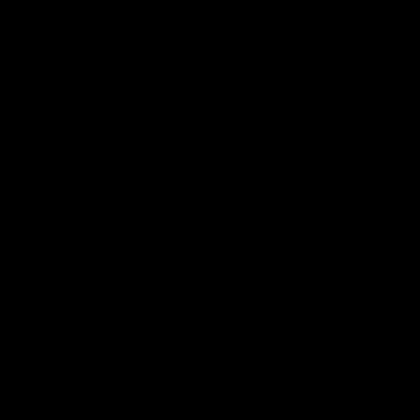

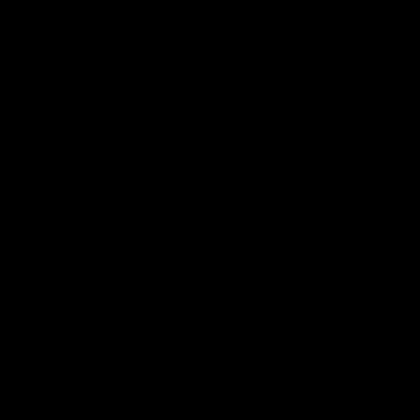

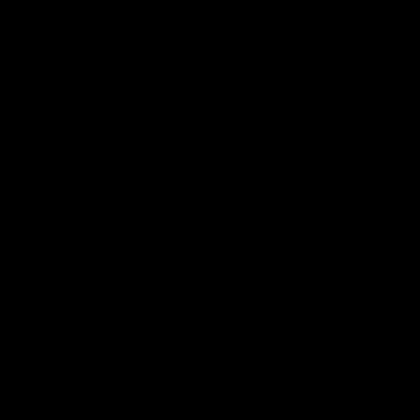

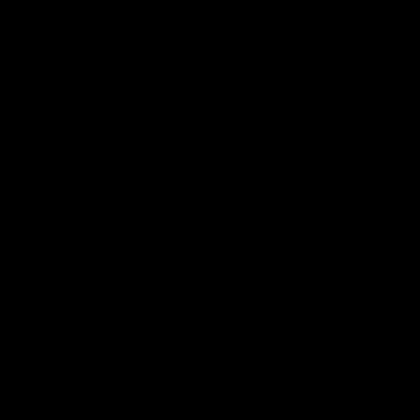

In [60]:
from google.colab.patches import cv2_imshow
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.datasets import mnist
import numpy as np
import argparse
import pickle
import os
import numpy as np
from keras.preprocessing import image
from keras.preprocessing.image import img_to_array
from imutils import build_montages
import cv2

def euclidean(a, b):
	# compute and return the euclidean distance between two vectors
	return np.linalg.norm(a - b)

def perform_search(queryFeatures, index, maxResults=64):
	# initialize our list of results
	results = []

	# loop over our index
	for i in range(0, len(index["features"])):
		# compute the euclidean distance between our query features
		# and the features for the current image in our index, then
		# update our results list with a 2-tuple consisting of the
		# computed distance and the index of the image
		d = euclidean(queryFeatures, index["features"][i])
		results.append((d, i))

	# sort the results and grab the top ones
	results = sorted(results)[:maxResults]

	# return the list of results
	return results

model = "/content/bioxtronomy/output/autoencoder.h5"
index = "/content/bioxtronomy/output/index.pickle"
sample = 2

# load the dataset
print("[INFO] loading dataset...")

# PATH = os.getcwd()

train_path = '/content/bioxtronomy/data/train/bio/'
train_batch = os.listdir(train_path)
x_train = []

# if data are in form of images
for sample in train_batch:
    img_path = train_path + sample
    x = image.load_img(img_path, color_mode="grayscale", target_size=(28,28))
    img_array = img_to_array(x)
    # preprocessing if required
    x_train.append(img_array)

test_path = '/content/bioxtronomy/data/test/astronomy/'
test_batch = os.listdir(test_path)
x_test = []

for sample in test_batch:
    img_path = test_path + sample
    x = image.load_img(img_path, color_mode="grayscale", target_size=(28,28))
    img_array = img_to_array(x)
    # preprocessing if required
    x_test.append(img_array)

# finally converting list into numpy array
trainX = np.array(x_train)
testX = np.array(x_test)

trainX = trainX.astype("float32") / 255.0
testX = testX.astype("float32") / 255.0

# load the autoencoder model and index from disk
print("[INFO] loading autoencoder and index...")
autoencoder = load_model(model)
index = pickle.loads(open(index, "rb").read())

# create the encoder model which consists of *just* the encoder
# portion of the autoencoder
encoder = Model(inputs=autoencoder.input, 
                outputs=autoencoder.get_layer("encoded").output)

# quantify the contents of our input testing images using the encoder
print("[INFO] encoding testing images...")
features = encoder.predict(testX)

queryIdxs = np.array([1,4,6,7])
# loop over the testing indexes
for i in queryIdxs:
    # take the features for the current image, find all similar
    # images in our dataset, and then initialize our list of result
    # images
    queryFeatures = features[i]
    results = perform_search(queryFeatures, index, maxResults=225)
    images = []

    # loop over the results
    # for (d, j) in results:
    #     # grab the result image, convert it back to the range
    #     # [0, 255], and then update the images list
    #     image = (trainX[j] * 255).astype("uint8")
    #     image = np.dstack([image] * 3)
    #     images.append(image)

    # display the query image
    query = (testX[i] * 255).astype("uint8")
    # img = cv2.imread("Query", query)
    cv2_imshow(query)
    
    # build a montage from the results and display it
    montage = build_montages(images, (28, 28), (15, 15))[0]
    # imgs = cv2.imread("Results", montage)
    cv2_imshow(montage)
    cv2.waitKey(0)